# Predicting the condition of patient based on the drug review given by the patient

In this project, the drug review dataset by UC Irvine (Available in Kaggle) was used to the predict the condition of the patient. Natural Language Processing was used to process the text and then predict the output. The first few steps are added to download the dataset from Kaggle directly.

In [5]:
'''Installing Kaggle to directly download the dataset and connect my google colab
directly to the Kaggle datasets'''
!pip install kaggle

In [6]:
!pwd

/content


In [7]:
#Importing the Kaggle.json file from the GDrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
!mkdir -p  ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
#Permission change settings
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets list

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                     📚 Students Performance Dataset 📚                  66KB  2024-06-12 23:09:20           3316         63  1.0              
mayankanand2701/samsung-stock-price-dataset                     Samsung Stock Price Dataset 📱🏭📈                  114KB  2024-06-13 14:51:11           1120         29  1.0              
shreyanshverma27/online-sales-dataset-popular-marketplace-data  Online Sales Dataset - Popular Marketplace Data    7KB  2024-05-25 23:55:26          10865        195  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024               Most Stream

In [10]:
!kaggle datasets download jessicali9530/kuc-hackathon-winter-2018

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018
License(s): other
 93% 38.0M/40.7M [00:00<00:00, 60.3MB/s]
100% 40.7M/40.7M [00:00<00:00, 51.7MB/s]


In [11]:
#Unizipping the files from the dataset
!unzip 'kuc-hackathon-winter-2018.zip'

Archive:  kuc-hackathon-winter-2018.zip
  inflating: drugsComTest_raw.csv    
  inflating: drugsComTrain_raw.csv   


# Starting the data Analysis on the dataset

In [12]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt


In [13]:
df = pd.read_csv('drugsComTrain_raw.csv')
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [14]:
df['review'][3]

'"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"'

In [15]:
df.condition.value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

In [16]:
'''It is better that we only take the top 4 frequency, as we would be able to
better predict the outcomes with the smaller dataset'''

df_train = df[(df['condition']=='Birth Control')|(df['condition']=='Depression')|(df['condition']=='Pain')|(df['condition']=='High Blood Pressure')]
df_train.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54
14,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10


In [17]:
column_names = ['uniqueID', 'drugName','usefulCount','rating','date']
X = df_train.drop(columns = column_names)

In [18]:
X.shape

(46323, 2)

In [19]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
9,Birth Control,"""I had been on the pill for many years. When m..."
11,Depression,"""I have taken anti-depressants for years, with..."
14,Birth Control,"""Started Nexplanon 2 months ago because I have..."


In [20]:
X['review']

2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
9         "I had been on the pill for many years. When m...
11        "I have taken anti-depressants for years, with...
14        "Started Nexplanon 2 months ago because I have...
                                ...                        
161271    "My experience: Painful insertion but I expect...
161273    "I have had the Nexplanon since Dec. 27, 2016 ...
161286    "This is the third med I&#039;ve tried for anx...
161290    "I have only been on Tekturna for 9 days. The ...
161291    "This would be my second month on Junel. I&#03...
Name: review, Length: 46323, dtype: object

In [21]:
X['review'][3]

'"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"'

In [22]:
#Now, we separate the dataset for each type of diesease

X_birth = X[X['condition']=='Birth Control']
X_depression = X[X['condition']=='Depression']
X_pain = X[X['condition']=='Pain']
X_highbp = X[X['condition']=='High Blood Pressure']

In [23]:
#We now plot the wordplots and for that we import the function needed for plotting the wordplot
from wordcloud import WordCloud

Text(0.5, 1.0, 'Cloud Plot for the Review of Birth Control')

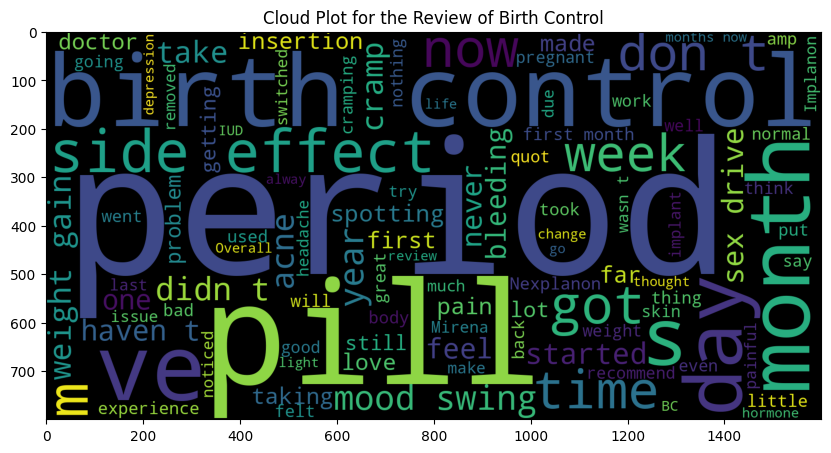

In [24]:
plt.figure(figsize=(10,10))
w = WordCloud(max_words=100, width=1600, height=800).generate(' '.join(X_birth['review']))
plt.imshow(w)
plt.title('Cloud Plot for the Review of Birth Control')

Text(0.5, 1.0, 'Cloud Plot for the Review of High Blood Pressure')

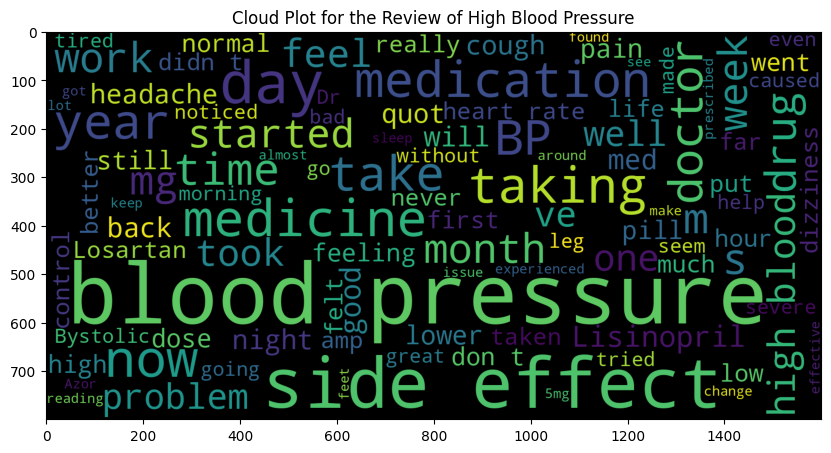

In [52]:
plt.figure(figsize=(10,10))
w = WordCloud(max_words=100, width=1600, height=800).generate(' '.join(X_highbp['review']))
plt.imshow(w)
plt.title('Cloud Plot for the Review of High Blood Pressure')

Text(0.5, 1.0, 'Cloud Plot for the Review of Depression')

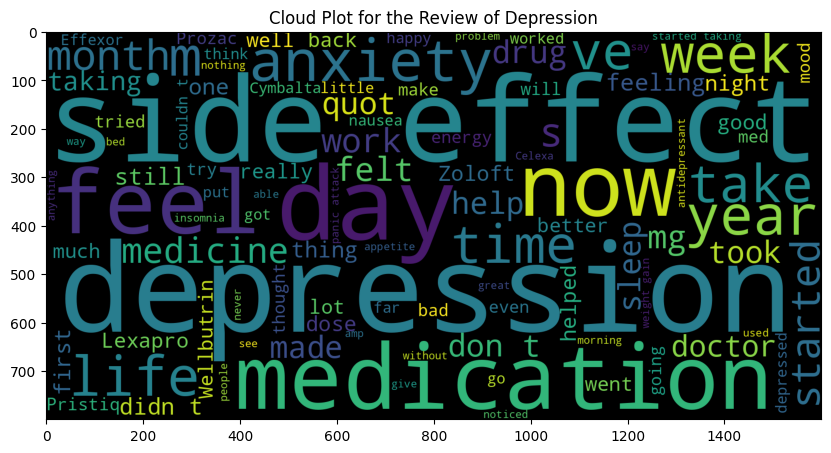

In [51]:
plt.figure(figsize=(10,10))
w = WordCloud(max_words=100, width=1600, height=800).generate(' '.join(X_depression['review']))
plt.imshow(w)
plt.title('Cloud Plot for the Review of Depression')

In [26]:
for i, col in enumerate(X_birth.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"',' ')

In [27]:
X['review'][11]

' I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects. '

In [28]:
X.head()

,condition,review
2,Birth Control,"I used to take another oral contraceptive, wh..."
3,Birth Control,This is my first time using any form of birth...
9,Birth Control,I had been on the pill for many years. When m...
11,Depression,"I have taken anti-depressants for years, with..."
14,Birth Control,Started Nexplanon 2 months ago because I have...


# NLP Section

In [29]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopper = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
print(stopper)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [31]:
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [32]:
def text_preprocess(review_raw_text):
  #Delete HTML portions
  review_text = BeautifulSoup(review_raw_text, 'html.parser').get_text()
  letters = re.sub('[^a-zA-Z]', ' ', review_text)    #keeping only the letters
  words = letters.lower().split()                    #converting into lowercase
  words = [w for w in words if w not in stopper]     #removing the stopwords

  #lemmatization and joining of the words
  lemmatize_text = [lemmatizer.lemmatize(w) for w in words]
  lemmatize_text = ' '.join(lemmatize_text)


  return lemmatize_text


In [33]:
X['updated_review'] = X['review'].apply(text_preprocess)
X.head()

<ipython-input-32-034d2d5577a3>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review_raw_text, 'html.parser').get_text()


,condition,review,updated_review
2,Birth Control,"I used to take another oral contraceptive, wh...",used take another oral contraceptive pill cycl...
3,Birth Control,This is my first time using any form of birth...,first time using form birth control glad went ...
9,Birth Control,I had been on the pill for many years. When m...,pill many year doctor changed rx chateal effec...
11,Depression,"I have taken anti-depressants for years, with...",taken anti depressant year improvement mostly ...
14,Birth Control,Started Nexplanon 2 months ago because I have...,started nexplanon month ago minimal amount con...


In [34]:
X_send = X['updated_review']
y = X['condition']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_send, y, stratify = y,  test_size=0.2, random_state=0)

# Using the Bag of Words models on the processed text

**Bag of Words Model**

In [36]:
#Creating the bag of words model
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [37]:
#Using the Naive Bayes Machine Learning model for the dataset:
multi_nb = MultinomialNB()
multi_nb.fit(count_train, y_train)

preds = multi_nb.predict(count_test)
accu_score = metrics.accuracy_score(y_test, preds)
print("The accuracy of the MultinomialNB model for the Bag of Words model is:", accu_score)

The accuracy of the MultinomialNB model for the Bag of Words model is: 0.9660010793308149


In [38]:
#We do the same for the Passive Aggressive Classifier

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)

preds = passive.predict(count_test)
accu_score = metrics.accuracy_score(y_test, preds)
print("The accuracy of the PassiveAggressiveClassifier model for the Bag of Words model is:", accu_score)

The accuracy of the PassiveAggressiveClassifier model for the Bag of Words model is: 0.974635725849973


# Using TFIDF on the text dataset

**TFIDF**

In [39]:
#TFIDF model is now been created for further analysis of the text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [40]:
# We now complete the Multinomial Naive Bayes for the tfidf
multi_nb_tf = MultinomialNB()
multi_nb_tf.fit(tfidf_train, y_train)

multi_nb_tf_preds = multi_nb_tf.predict(tfidf_test)
accu_score = metrics.accuracy_score(y_test, multi_nb_tf_preds)
print("The accuracy of the MultinomialNB model for the TFIDF model is:", accu_score)

The accuracy of the MultinomialNB model for the TFIDF model is: 0.9231516459794927


In [41]:
#Passive Aggressive Classifier for the tfidf
passive_tf = PassiveAggressiveClassifier()
passive_tf.fit(tfidf_train, y_train)

passive_tf_preds = passive_tf.predict(tfidf_test)
accu_score = metrics.accuracy_score(y_test, passive_tf_preds)
print("The accuracy of the PassiveAggressiveClassifier model for the TFIDF model is:", accu_score)

The accuracy of the PassiveAggressiveClassifier model for the TFIDF model is: 0.9788451160280626


**Using TFIDF bigrams**

We now use the tfidf bigrams for the further analysis of the text and then see if the model performs better for bigrams.

In [42]:
tfidf_vectorizer_bigram = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df = 0.8)
tfidf_train_2 = tfidf_vectorizer_bigram.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer_bigram.transform(X_test)

In [43]:
passive_tf.fit(tfidf_train_2, y_train)
passive_tf_preds = passive_tf.predict(tfidf_test_2)
accu_score = metrics.accuracy_score(y_test, passive_tf_preds)
print("The accuracy of the PassiveAggressiveClassifier model for the TFIDF model is:", accu_score)

The accuracy of the PassiveAggressiveClassifier model for the TFIDF model is: 0.9840259039395575


**TFIDF:Trigrams**

We now do further analysis by using trigrams so that we can see if the accuracy of the model increases.

In [44]:
tfidf_vectorizer_trigram = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_df = 0.8)
tfidf_train_3 = tfidf_vectorizer_trigram.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer_trigram.transform(X_test)

In [45]:
passive_tf.fit(tfidf_train_3, y_train)
passive_tf_preds = passive_tf.predict(tfidf_test_3)
accu_score = metrics.accuracy_score(y_test, passive_tf_preds)
print("The accuracy of the PassiveAggressiveClassifier model for the TFIDF model is:", accu_score)

The accuracy of the PassiveAggressiveClassifier model for the TFIDF model is: 0.9828386400431732


# Testing the model on the test dataset
We know use our trained model on the test dataset for samples which it was tested upon. And then we obtain the results for our model.

In [46]:
tester = pd.read_csv('drugsComTest_raw.csv')
tester.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [47]:
tester.drop(columns = column_names, inplace = True)
tester.head()

,condition,review
0,Depression,"""I&#039;ve tried a few antidepressants over th..."
1,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ..."
2,Urinary Tract Infection,"""Quick reduction of symptoms"""
3,Weight Loss,"""Contrave combines drugs that were used for al..."
4,Birth Control,"""I have been on this birth control for one cyc..."


In [48]:
tester = tester[(tester['condition']=='Birth Control')|(tester['condition']=='Depression')|(tester['condition']=='Pain')|(tester['condition']=='High Blood Pressure')]
tester.head()

,condition,review
0,Depression,"""I&#039;ve tried a few antidepressants over th..."
4,Birth Control,"""I have been on this birth control for one cyc..."
6,Birth Control,"""I&#039;ve had the copper coil for about 3 mon..."
9,Birth Control,"""I was on this pill for almost two years. It d..."
30,Birth Control,"""I absolutely love this product and recommend ..."


In [49]:
def recommend_drugs(condition):
  df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating','usefulCount'], ascending = [False,False])
  drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
  return drug_lst

In [50]:
def predict_condition(review):
  df_test = pd.DataFrame(review, columns= ['test_text'])
  df_test['text_test'] = df_test['text_test'].apply(text_preprocess)
  #review = text_preprocess(review)

  vec_res = tfidf_vectorizer_trigram.transform(df_test['text_test'])
  preds = passive_tf.predict(vec_res)
  df_test['predictions'] = preds

  return df_test